In [35]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Module to see files and folders in directories
from scipy import stats
from scipy.stats import binom
from scipy.special import binom as binomcoef
import pandas as pd
from sympy import *
import os
from importlib import reload

sys.path.append('../External_Functions')
import ExternalFunctions
reload(ExternalFunctions)
from ExternalFunctions import UnbinnedLH, BinnedLH, Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax, add_header_to_ax

# Problem 1
#### (1.1)

In [4]:
# 3 white balls, 6 black balls and 7 grey balls 

# Part 1
# If you take two random marbles without putting them back,
# what is the probability that at least one of them is white?

# 1 ball draw
white = 3
total = 16
chance1 = white/total * (total-white)/(total-1) * binomcoef(2,1)

# 2 ball draw
chance2 = white/total * ((white-1)/(total-1))

totalchance1 = chance1 + chance2
# Important to note that this example is not a binomial distribution but a hypergeometric distribution (https://en.wikipedia.org/wiki/Hypergeometric_distribution).
# The problem can therefore be solved by using it.
draws = 2
totalchance2 = 0

for success in range(1,3):
    chance = binomcoef(white, success) * binomcoef(total-white, draws - success) / binomcoef(total, draws)
    totalchance2 += chance

print(totalchance1, totalchance2)

# Part 2
# If you pick a marble, record its color, and then put it back 25 times independently, 
# what is the probability of getting exactly 18 grey marbles? At least 18 grey marbles?

# In this problem the ball is put back, so the probability simply follow a binomial distribution
grey = 7
draws = 25
success = 18
grey18_chance = (grey/total)**success * (1 - grey/total)**(draws - success) * binomcoef(draws, success)
print(grey18_chance)
grey18above_chance = 0
for success in range(18, draws + 1):
    chance = (grey/total)**success * (1 - grey/total)**(draws - success) * binomcoef(draws, success)
    grey18above_chance += chance
print(grey18above_chance)

# Part 3

# If you got 18 grey marbles out of 25 picks, would you trust your friend’s information?
# I know the probablity of getting my result or worse is 0.004, which is very unlikely, so I would not trust him.
# Further draws would also be able to confirm or deny this proposition.
grey = 7
total = 16
draws = 25
success = 18
p = grey/total
mu = p * draws
# definition of std of a binominal distribution
std = np.sqrt(draws * p * (1-p))
chi2 = ((success - mu)/std)**2
# Ndof = 1 as we have only one data point 
prob = stats.chi2.sf(chi2, 1)
print(prob)
# Which is acutally larger than drawing 18 balls or more, but still the probability is too low to believe it comes from the configuration of balls described

0.35000000000000003 0.35000000000000003
0.002953499094615584
0.004039599792444155
0.004408730698241791


In [5]:
# The lifetime L of a certain component is exponentially distributed: L(t) = 1/τ exp(−t/τ ). 
# If there is a 4% chance of this component lasting more than 500 hours, what is the value of τ?

# So another way of fracing the question is: What value of τ gives a 96% probability of lasting less that or equal to 500 hours
# The integral gives -exp(-t/τ) which is easy to see
# evaluate the limits gives: -exp(-500/tau) + 1 so tau = -500/ln(0.04) = 500/ln(1/0.04) = 500/ln(25)
# We can test that it works:
step = 0.00001
t = np.arange(0, 500 + step, step)
tau = 500/np.log(25)
def L(t, tau, step):
    return step * 1/tau * np.exp(-t/tau)
Ltot = L(t, tau, step)
p = np.sum(Ltot)
print(p)
# The disagreement arise from my not infitimisal dt in the integration. But as I solved to analyticly, I know it is correct

0.9600000334763076


#### (1.3)

In [6]:
# A radio telescope detects 241089 signals/day, based on a 9 week observation campaign.

# Part 1
# One hour, it receives 9487 signals. What is the chance of observing exactly this number?

# This problem seems to follow possion statistics. Lets first try to solve it using the propapility formular for possion, and if we cannot, we will divert to a gaussian distribution with the same width and mean.

# The average number of signals per hour is.
lamb = 241089/24 #lambda
print(lamb)
r = 9487
# prob = np.exp(-lamb)*lamb**r/np.factorial(r)
# This gives an overflow error.
# Instead we convert the possion distribution to a gaussian
mu = lamb
sigma = np.sqrt(lamb)
print(lamb, sigma)
def gauss(x, mu, sigma):
    return 1/(sigma * np.sqrt(2*np.pi)) * np.exp(-1/2 * ((x - mu) / sigma)**2)

prob1 = gauss(r, mu, sigma)
print(prob1) # p = 7.2483E-10
# As the gaussian is quite flat this far from the mean the value at the point is a good approximation of the integral from r - 0.5 to r + 0.5
# To test this we can do a numerical integration.
# for 1000 points the integral is correct to the 6th decimal, for 10000 to the 7th
points = 10000
x_points = np.linspace(r - 0.5, r + 0.5, points)
prob2 = np.sum(gauss(x_points, mu, sigma)/points)
print(prob2) # p =  7.2492E-10
# As we see, I was correct in my assumsion.
# The probability is insanely low for exactly that amount in 1 given hour
# but what is the chance of it happening once during the 9 weeks. 
hours = 24 * 7 * 9
prob3 = prob2 * binomcoef(hours, 1) 
print(prob3) # p = 1.096E-6
# So that is the chance of exactly that amount landing in one 1 hour interval over the 9 weeks. 

# Part 2
# Is this observation extraordinary, based on an estimate of its general probability?

# But a more fair question is to ask what is the probability of that amount of less to be detected in a 1 hour interval
# As each amount is unlikely in order to know if it is unordinary I need to know how likely it is to get the result or something similar.
# I should in theory integrate from -inf to r + 0.5, but as the area under the curve is bound and decreasing exponantially in magnitude
# It is a good approximation to integrate from r - 5 * sigma to r + 0.5
# I will use 1000 points per number in the integral
integral_points = round(points * (5 * sigma + 0.5)/10)
x_points2 = np.linspace(r - 5 * sigma, r + 0.5, integral_points)
prob4 = np.sum(gauss(x_points2, mu, sigma)/(points/10))
print(prob4) # gives 1.30228E-8. The true integral gives 1.30225E-08
# There is a very small over estimation due to the size of the steps, but correct to the 5th decimal
# So finally the chance of seeing 9487 signals or less in a one hours interval during 9 weeks is, given the observations is
prob5 = prob4 * (1-prob4)**(hours-1) * binomcoef(hours, 1)
print(prob5) # p = 0.0000197
# Which is close to 1 in 50000. That is very unlikely, so the observation is very extrodinary. 
# It would be weird to make a chi2 when we are missing all the other observations which should be included in such an analysis

10045.375
10045.375 100.22661822090976
7.248269381795693e-10
7.249172658111802e-10
1.0960749059065045e-06
1.3022835193618969e-08
1.969013935614327e-05


In [7]:
# Shooting with a bow, you have 3% chance of hitting a certain target.

# Part 1
# What distribution is the number of hits going to follow, given N shots?
# The probablility should follow a binominal distribution.
# binom(N, r) * 0.03**r * (1-0.03)**(N-r)

# Part 2 
# What is the probability that the first hit will come after 20 shots?
# I ask alternatively: What is the probability of not hitting in the first 20 shots
def bowdist(N, r, p):
    return binomcoef(N, r) * p**r * (1-p)**(N-r)

p = 0.03
N = 20
r = 0
prob1 = bowdist(N, r, p)
print(prob1) # p = 0.544
# The probability of getting the first hit after 20 shots is 0.544

# Part 3 
# What is the probability that it will take more than 4000 shots to hit the target 100 times?
# Again, lets just answer what the chance is to get 100 or more hits in 4000 shots.
# The mean of the distribution is Np: mu = 120
# The std = 10.79
# So the integration from r = 100 to r = 170 seems resonable, we cannot have too large r, as that will result in an overflowerror
N = 4000
r = np.arange(100, 171)
prob2 = np.sum(bowdist(N, r, p))
print(prob2) # p = 0.9739
print(1- prob2) # p = 0.02609
print(binom.cdf(99, N, p))
# So the chance of using more than 4000 shots to get 100 hits is only 0.03 
# (Think about number of significant decimals. Is this correct as p is given with only 1 decimal?)

0.543794342926747
0.9739068133404871
0.02609318665951288
0.026088297763255112


# Problem 2
#### (2.1)

In [8]:
#  Let x = 1.92 ± 0.39 and y = 3.1 ± 1.3, and let z1 = y/x, and z2 = cos(x) · x/y.

# Part1 
# What are the uncertainties of z1 and z2, if x and y are uncorrelated?

# Define functions for z1 and z2 to get the value and the uncertainty using the gerenal error function.
def z1(vals, sigmas):
    xSym, ySym = symbols("x y")
    symlist = [xSym, ySym]
    
    z = ySym / xSym
    
    def variances(func, symbols, values, sigmas):
        variance = np.zeros(len(symbols))
        for idx, (symbol, sigma) in enumerate(zip(symbols,sigmas)):
            f = lambdify(symbols, func.diff(symbol)**2 * sigma **2)
            variance[idx] = f(*values)
        return variance
    Vz = variances(z, symlist, vals, sigmas)
    print(Vz)
    sigmaz = np.sqrt(np.sum(Vz))
    zvalue = lambdify(symlist, z)(*vals)
    
    return zvalue, sigmaz

def z2(vals, sigmas):
    xSym, ySym = symbols("x y")
    symlist = [xSym, ySym]
    
    z = cos(xSym) * xSym / ySym
    
    def variances(func, symbols, values, sigmas):
        variance = np.zeros(len(symbols))
        for idx, (symbol, sigma) in enumerate(zip(symbols,sigmas)):
            f = lambdify(symbols, func.diff(symbol)**2 * sigma **2)
            variance[idx] = f(*values)
        return variance
    Vz = variances(z, symlist, vals, sigmas)
    
    sigmaz = np.sqrt(np.sum(Vz))
    zvalue = lambdify(symlist, z)(*vals)
    
    return zvalue, sigmaz


# I define the variaables
x = 1.92
sigmax = 0.39
y = 3.1
sigmay = 1.3 
# Use functions to get values
z1value, sigmaz1 = z1((x, y), (sigmax, sigmay))
z2value, sigmaz2 = z2((x, y), (sigmax, sigmay))
print(f"z1 = {z1value:.3f} +/- {sigmaz1:.3f}")
print(f"z2 = {z2value:.3f} +/- {sigmaz2:.3f}")
# I get sigma z1 = 0.8 and sigma z1 = 0.3

# Part2
# If x and y were highly correlated (ρxy = 0.95), what would be the uncertainty on z1?

# Remake function to include correlation
def z1(vals, sigmas, corrmatrix):
    xSym, ySym = symbols("x y")
    symlist = [xSym, ySym]
    
    z = ySym / xSym
    
    def variances(func, symbols, values, sigmas, corrmatrix):
        # Make a variance matrix which can we summed and sqrt'ed to find the uncertainty
        # ***Need to be rework to it make more general for more correlations*** 
        # ***Would also be nice to not have a nested loop
        variance = np.zeros((len(symbols), len(symbols)))
        for idx, (isymbol, isigma) in enumerate(zip(symbols,sigmas)):
            for jdx, (jsymbol, jsigma) in enumerate(zip(symbols,sigmas)):
                
                f = lambdify(symbols, func.diff(isymbol) * func.diff(jsymbol) * isigma * jsigma * corrmatrix[idx, jdx])
                variance[idx, jdx] = f(*values)
        
        return variance
    Vz = variances(z, symlist, vals, sigmas, corrmatrix)
    print(Vz)
    sigmaz = np.sqrt(np.sum(Vz.flatten()))
    zvalue = lambdify(symlist, z)(*vals)
    
    return zvalue, sigmaz

x = 1.92
sigmax = 0.39
y = 3.1
sigmay = 1.3 
corrs = np.array([[1, 0.95],
                  [0.95, 1]])

z1value, z1sigma = z1((x, y), (sigmax, sigmay), corrs)
print(f"z1 = {z1value:.1f} +/- {z1sigma:.1f}")
# The uncertainty becomes 0.4, and thereby decreases by 0.4 because of the corralation between x and y

# Part 3
# Which of the (uncorrelated) variables x and y contributes most to the uncertainty on z2?

# modify the z2 function to print the "variance matrix"
def z2(vals, sigmas):
    xSym, ySym = symbols("x y")
    symlist = [xSym, ySym]
    
    z = cos(xSym) * xSym / ySym
    
    def variances(func, symbols, values, sigmas):
        variance = np.zeros(len(symbols))
        for idx, (symbol, sigma) in enumerate(zip(symbols,sigmas)):
            f = lambdify(symbols, func.diff(symbol)**2 * sigma **2)
            variance[idx] = f(*values)
        return variance
    Vz = variances(z, symlist, vals, sigmas)
    print(Vz)
    sigmaz = np.sqrt(np.sum(Vz))
    zvalue = lambdify(symlist, z)(*vals)
    
    return zvalue, sigmaz, Vz

x = 1.92
sigmax = 0.39
y = 3.1
sigmay = 1.3 

z2value, z2sigma, (Vz2_x, Vz2_y) = z2((x, y), (sigmax, sigmay))
p_x = Vz2_x/(Vz2_x + Vz2_y)
print(p_x)
# For z2 the variance contribution from x is 90% and is therefore much greater than y

[0.10755923 0.45844184]
z1 = 1.615 +/- 0.752
z2 = -0.212 +/- 0.284
[[ 0.10755923 -0.21095488]
 [-0.21095488  0.45844184]]
z1 = 1.6 +/- 0.4
[0.07290782 0.00789723]
0.9022681538577463


#### (2.2)

In [9]:
# Five patients were given a drug to test if they slept longer (in hours). 
# Their results were:               +3.7, −1.2, −0.2, +0.7, +0.8. 
# A Placebo group got the results:  +1.5, −1.0, −0.7, +0.5, +0.1.

# Part 1 
# Estimate the mean, standard deviation, and the uncertainty on the mean for drug group.

# First I assume that the patients' results are not correlated
dg = [3.7, -1.2, -0.2, 0.7, 0.8]
def get_stats(data):
    mean = np.mean(data)
    std = np.std(data, ddof = 1)
    eom = std/np.sqrt(len(data))
    return mean, std, eom
dg_mean, dg_std, dg_eom = get_stats(dg)
print(f"The drug groups results is: mean = {dg_mean:.1f} +/- {dg_eom:.1f} with a std = {dg_std:.1f}")
# The drug groups results is: mean = 0.8 +/- 0.8 with a std = 1.8

# Part 2 
# What is the probability that the drug group slept longer than the placebo group?
pg = [1.5, -1.0, -0.7, 0.5, 0.1]

pg_mean, pg_std, pg_eom = get_stats(pg)
print(f"The placebo groups results is: mean = {pg_mean:.1f} +/- {pg_eom:.1f} with a std = {pg_std:.1f}")


# What I want to find is the probability that the diference between the two distributions is larger than 1
# The expected mean of the difference of the two distributions is just the difference of the means 
# I can use error propagartion to find variance in the difference of two random numbers from the two distributions
# V = 1**2 * simga_drug**2 + (-1)**2 * sigma_placebo**2
dif_mean = dg_mean - pg_mean
dif_sigma = np.sqrt(dg_eom **2 + pg_eom **2)
print( f"Difference is normal distributed with mean = {dif_mean:.4f} and std = {dif_sigma:.4f} ")
# The integral is computed numericly from 0 to +5sigma with 10000 pints per integer

x_min = 0
x_max = dif_mean + 6 * dif_sigma
ppi = 10000

def fx(x):
    return 1/(dif_sigma * np.sqrt(2 * np.pi)) * np.exp(-1/2 * (x-dif_mean)**2 / dif_sigma **2)
def num_int(func, xmin, xmax, ppi):
    x = np.linspace(xmin, xmax, floor(ppi * (xmax - xmin)))
    return np.sum(func(x))/ppi
p = num_int(fx, x_min, x_max, ppi)
print(p) 

The drug groups results is: mean = 0.8 +/- 0.8 with a std = 1.8
The placebo groups results is: mean = 0.1 +/- 0.4 with a std = 1.0
Difference is normal distributed with mean = 0.6800 and std = 0.9322 
0.7671414998362956


# Problem 3
#### (3.1)

In [13]:
# Assume f(x) = C * x**a * sin(pi * x) for x in [0, 1] and a = 3 is a theoretical distribution. 

# Part 1 
# By what method(s) would you generate random numbers according to f(x)?

# The distribution is dependent on x in two different ways which makes it difficult to integrate and invert. 
# Therefore, I will use the accept/reject method.

# Part 2
# Determine (possibly numerically) the value of C for f(x) to be normalised.

# I will determine C by numerical integration, and check the area after doing the reject/accept to make sure the resolution of the integration is sufficient
def fx_unnorm(x):
    return 1 * x**3 * np.sin(np.pi * x)

def num_int(func, xmin, xmax, ppi):
    x = np.linspace(xmin, xmax, floor(ppi * (xmax - xmin)))
    return np.sum(func(x))/ppi
xmin = 0
xmax = 1
ppi = 100000
area = num_int(fx_unnorm, xmin, xmax, ppi)
print(area)
# if no C is include the area = 0.124799
C = 1/area
print(C)
# so C = 8.013

def fx_norm(x):
    global C
    return C * x**3 * np.sin(np.pi * x)

r = np.random

def acceptreject(func, xmin, xmax, ymin, ymax, N_points):
    # Recursive function to do accept/reject monte carlo simulation
    xran = r.uniform(xmin, xmax, N_points)
    yran = r.uniform(ymin, ymax, N_points)
    xfunc = func(xran)
    xkeep = xran[xfunc > yran]
    missing = N_points - len(xkeep)
    if missing > 0:
        xrest, tries = acceptreject(func, xmin, xmax, ymin, ymax, missing)
    else:
        xrest = np.array([])
        tries = 0
    finalx = np.append(xkeep, xrest)
    finaltries = N_points + tries
    return finalx, finaltries

# Calc y max
xlin = np.linspace(0, 1, 100000)
ymax = np.max(fx_norm(xlin))

xmin = 0
xmax = 1
ymin = 0
N_points = 16000
xdis, tries = acceptreject(fx_norm, xmin, xmax, ymin, ymax, N_points)



0.12479943155161771
8.01285701038145


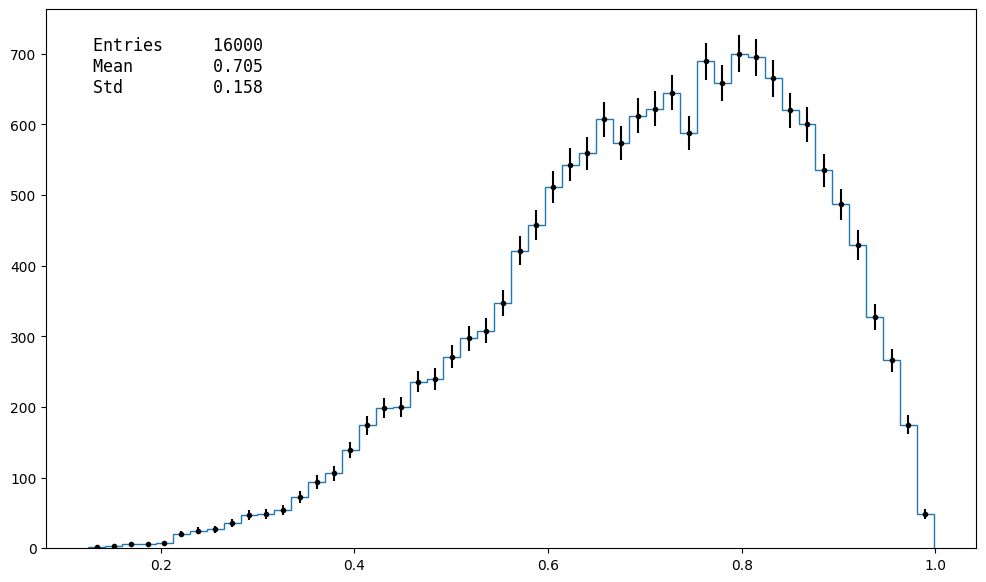

In [36]:
N_bins = 50
xcount, interval = np.histogram(xdis, N_bins)
xerr = np.sqrt(xcount)
xpos = (interval[1:] + interval[:-1])/2
fig, ax = plt.subplots(1, 1, figsize = (12,7), facecolor = "white")

ax.hist(xdis, bins = N_bins, histtype = "step")
ax.errorbar(xpos, xcount, yerr = xerr, fmt = ".", ecolor = "k", color = "k")
add_header_to_ax(xdis, 0.05, 0.95, ax)